# Графовые нейронные сети с вниманием

In [1]:
import numpy as np
np.random.seed(0)

A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])
A

array([[1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 1, 1]])

In [2]:
X = np.random.uniform(-1, 1, (4, 4))
X

array([[ 0.09762701,  0.43037873,  0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823, -0.12482558,  0.783546  ],
       [ 0.92732552, -0.23311696,  0.58345008,  0.05778984],
       [ 0.13608912,  0.85119328, -0.85792788, -0.8257414 ]])

In [3]:
W = np.random.uniform(-1, 1, (2, 4))
W

array([[-0.95956321,  0.66523969,  0.5563135 ,  0.7400243 ],
       [ 0.95723668,  0.59831713, -0.07704128,  0.56105835]])

In [4]:
W_att = np.random.uniform(-1, 1, (1, 4))
W_att

array([[-0.76345115,  0.27984204, -0.71329343,  0.88933783]])

In [5]:
connections = np.where(A > 0)
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

In [6]:
np.concatenate(
    [
        (X @ W.T)[connections[0]], 
        (X @ W.T)[connections[1]]
    ], axis=1)

array([[ 0.37339233,  0.38548525,  0.37339233,  0.38548525],
       [ 0.37339233,  0.38548525,  0.85102612,  0.47765279],
       [ 0.37339233,  0.38548525, -0.67755906,  0.73566587],
       [ 0.37339233,  0.38548525, -0.65268413,  0.24235977],
       [ 0.85102612,  0.47765279,  0.37339233,  0.38548525],
       [ 0.85102612,  0.47765279,  0.85102612,  0.47765279],
       [-0.67755906,  0.73566587,  0.37339233,  0.38548525],
       [-0.67755906,  0.73566587, -0.67755906,  0.73566587],
       [-0.67755906,  0.73566587, -0.65268413,  0.24235977],
       [-0.65268413,  0.24235977,  0.37339233,  0.38548525],
       [-0.65268413,  0.24235977, -0.67755906,  0.73566587],
       [-0.65268413,  0.24235977, -0.65268413,  0.24235977]])

In [7]:
a = W_att @ np.concatenate(
    [
        (X @ W.T)[connections[0]], 
        (X @ W.T)[connections[1]]
    ], axis=1).T
a

array([[-0.1007035 , -0.35942847,  0.96036209,  0.50390318, -0.43956122,
        -0.69828618,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

In [8]:
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x, x)

e = leaky_relu(a)
e

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318, -0.08791224,
        -0.13965724,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

In [9]:
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]
E

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318],
       [-0.08791224, -0.13965724,  0.        ,  0.        ],
       [ 0.79964181,  0.        ,  1.8607074 ,  1.40424849],
       [ 0.64260322,  0.        ,  1.70366881,  1.2472099 ]])

In [10]:
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum

W_alpha = softmax2D(E, 1)
W_alpha

array([[0.15862414, 0.15062488, 0.42285965, 0.26789133],
       [0.24193418, 0.22973368, 0.26416607, 0.26416607],
       [0.16208847, 0.07285714, 0.46834625, 0.29670814],
       [0.16010498, 0.08420266, 0.46261506, 0.2930773 ]])

In [11]:
H = A.T @ W_alpha @ X @ W.T
H

array([[-1.10126376,  1.99749693],
       [-0.33950544,  0.97045933],
       [-1.03570438,  1.53614075],
       [-1.03570438,  1.53614075]])

In [12]:
from torch_geometric.datasets import Planetoid

# импортируем набор Cora с помощью PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

In [13]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, 
                                     weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], 
                             data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), 
                           data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], 
                                     data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), 
                                   data.y[data.val_mask])
                print(f'Эпоха {epoch:>3}:\n| Функция потерь на обуч. выборке: '
                      f'{loss:.3f} | Правильность на обуч. выборке: '
                      f'{acc*100:>5.2f}% \n| Функция потерь на валид. '
                      f'выборке: {val_loss:.2f} | Правильность на валид. '
                      f'выборке: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], 
                       data.y[data.test_mask])
        return acc

# создаем модель GAT
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

# обучаем
gat.fit(data, epochs=100)

# тестируем
acc = gat.test(data)
print(f'Правильность GAT на тесте (Cora): {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Эпоха   0:
| Функция потерь на обуч. выборке: 1.969 | Правильность на обуч. выборке: 15.00% 
| Функция потерь на валид. выборке: 1.96 | Правильность на валид. выборке: 11.80%
Эпоха  20:
| Функция потерь на обуч. выборке: 0.259 | Правильность на обуч. выборке: 96.43% 
| Функция потерь на валид. выборке: 1.10 | Правильность на валид. выборке: 67.60%
Эпоха  40:
| Функция потерь на обуч. выборке: 0.163 | Правильность на обуч. выборке: 98.57% 
| Функция потерь на валид. выборке: 0.90 | Правильность на валид. выборке: 70.80%
Эпоха  60:
| Функция потерь на обуч. выборке: 0.205 | Правильность на обуч. выборке: 98.57% 
| Функция потерь на валид. выборке: 0.96 | Правильность на валид. выборке: 69.00%
Эпоха  80:
| Функция потерь на обуч. выборке: 0.130 | Правильность на обуч. выборке: 100.00% 
| Функция потерь на валид. выборке: 0.91 | Правильность на валид. выборке: 70.80%
Эпоха 100:
| Функция потерь на обуч. выбо

In [14]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

<BarContainer object of 32 artists>

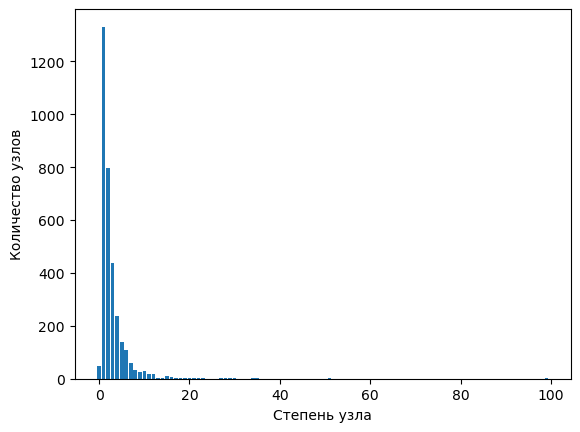

In [15]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# создаем список степеней
degrees = degree(dataset[0].edge_index[0]).numpy()

# вычисляем количество узлов для каждой степени
numbers = Counter(degrees)

# столбиковая диаграмма
fig, ax = plt.subplots()
ax.set_xlabel('Степень узла')
ax.set_ylabel('Количество узлов')
plt.bar(numbers.keys(), numbers.values())

In [16]:
# создаем модель GAT
gat = GAT(dataset.num_features, 16, dataset.num_classes)
print(gat)

# обучаем
gat.fit(data, epochs=100)

# тестируем
acc = gat.test(data)
print(f'Правильность GAT на тесте (CiteSeer): {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=1)
)
Эпоха   0:
| Функция потерь на обуч. выборке: 1.803 | Правильность на обуч. выборке: 15.83% 
| Функция потерь на валид. выборке: 1.81 | Правильность на валид. выборке: 16.60%
Эпоха  20:
| Функция потерь на обуч. выборке: 0.175 | Правильность на обуч. выборке: 96.67% 
| Функция потерь на валид. выборке: 1.15 | Правильность на валид. выборке: 60.40%
Эпоха  40:
| Функция потерь на обуч. выборке: 0.134 | Правильность на обуч. выборке: 97.50% 
| Функция потерь на валид. выборке: 1.22 | Правильность на валид. выборке: 62.00%
Эпоха  60:
| Функция потерь на обуч. выборке: 0.135 | Правильность на обуч. выборке: 97.50% 
| Функция потерь на валид. выборке: 1.21 | Правильность на валид. выборке: 61.60%
Эпоха  80:
| Функция потерь на обуч. выборке: 0.111 | Правильность на обуч. выборке: 100.00% 
| Функция потерь на валид. выборке: 1.15 | Правильность на валид. выборке: 63.60%
Эпоха 100:
| Функция потерь на обуч. выбо

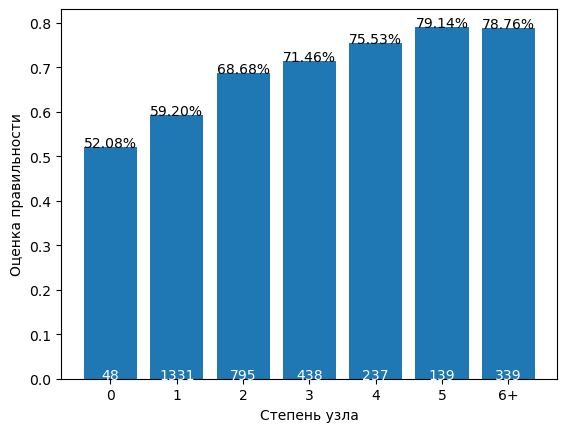

In [17]:
# получаем результаты
out = gat(data.x, data.edge_index)

# создаем список степеней
degrees = degree(data.edge_index[0]).numpy()

# здесь храним оценки правильности 
# и размеры степеней
accuracies = []
sizes = []

# правильность для степеней в диапазоне от 0 до 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], 
                               data.y[mask]))
    sizes.append(len(mask))

# правильность для степеней > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], 
                           data.y[mask]))
sizes.append(len(mask))

# столбиковая диаграмма
fig, ax = plt.subplots()
ax.set_xlabel('Степень узла')
ax.set_ylabel('Оценка правильности')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', 
             ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], 
             ha='center', color='white')